In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import webcolors
from PIL import Image, ImageDraw

import networkx as nx

from minimal.imaging import blit_rooms
from minimal.layout import NodeType, NODE_COLOR
from minimal.gen import PlanMasks
from minimal.rooms import RoomAreas, extract_rooms

%matplotlib inline

In [3]:
cmapr = ListedColormap(['white', *plt.get_cmap('tab10').colors])
cmapw = ListedColormap(['white', 'black', *plt.get_cmap('tab10').colors])

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


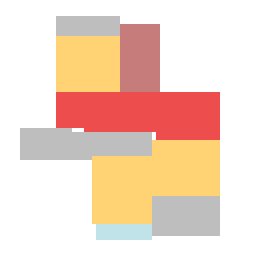

In [32]:
%%time
pm = PlanMasks.create_from_state(torch.load("data/plan_masks_02.pth"))
rooms = extract_rooms(pm)
rooms.sort(key=lambda r: r.total_area())
blit_rooms(rooms)

In [33]:
rect_mask = sum(room.to_mask() * (i + 1) for i, room in enumerate(rooms))

In [139]:
# plt.imshow(rect_mask, cmap=cmapr)

In [24]:
CC_TL = 1
CC_TR = 2
CC_BR = 4
CC_BL = 8

CC_T = 16
CC_R = 32
CC_B = 64
CC_L = 128

_dirs = [
    (-1, -1, CC_TL),
    (-1,  0, CC_T ),
    (-1,  1, CC_TR ),

    ( 0, -1, CC_L ),
    ( 0,  1, CC_R ),

    ( 1, -1, CC_BL),
    ( 1,  0, CC_B ),
    ( 1,  1, CC_BR),
]


In [16]:
max_x, max_y = rect_mask.shape

In [34]:
sep_mask = torch.zeros(rect_mask.shape, dtype=torch.uint8)

for x in range(max_x):
    for y in range(max_y):
        cell_room = rect_mask[x, y]

        for dx, dy, bit in _dirs:
            nx = x + dx
            ny = y + dy

            if nx < 0 or nx >= max_x or ny < 0 or ny >= max_y:
                continue

            n_room = rect_mask[nx, ny]

            if cell_room > n_room:
                sep_mask[x, y] += bit


In [37]:
scale_x = 4
scale_y = 4

scaled_sep_mask = torch.zeros(
    (sep_mask.shape[0] * scale_x, sep_mask.shape[1] * scale_y),
    dtype=torch.uint8
)

for x in range(max_x):
    for y in range(max_y):
        bx = x * scale_x
        by = y * scale_y

        nx = bx + scale_x
        ny = by + scale_y

        view = scaled_sep_mask[bx:nx, by:ny]
        src = sep_mask[x, y].item()

        view[ 0,  0] += src & CC_TL
        view[ 0, -1] += src & CC_TR
        view[-1, -1] += src & CC_BR
        view[-1,  0] += src & CC_BL

        view[ 0,  :] += src & CC_T
        view[ :, -1] += src & CC_R
        view[-1,  :] += src & CC_B
        view[ :,  0] += src & CC_L

In [154]:
# plt.figure(figsize=(10,5))

# plt.subplot(121)
# plt.imshow(scaled > 0)

# plt.subplot(122)
# plt.imshow(rect_mask, cmap=cmapr)

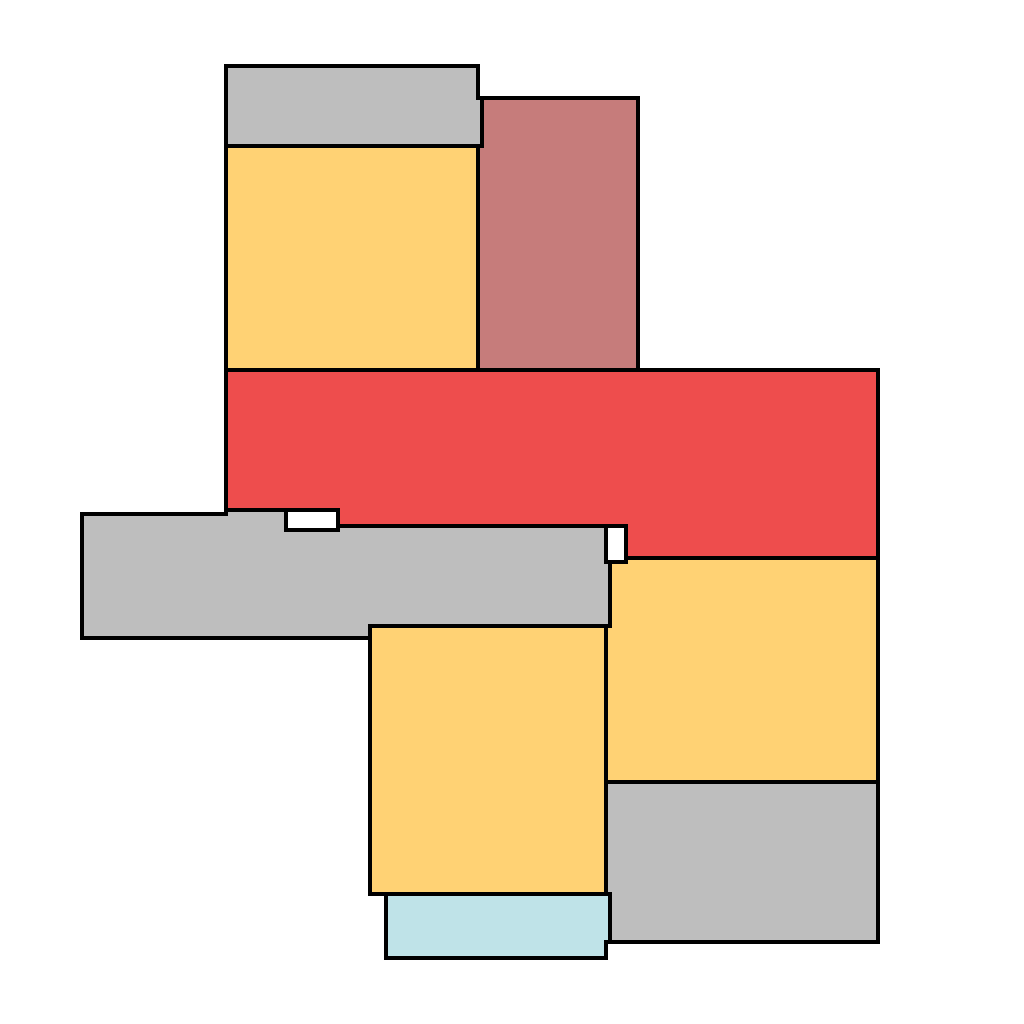

In [38]:
walls = (scaled_sep_mask > 0).byte()

h = rooms[0].grid_height
w = rooms[0].grid_width

plan_img = Image.new("RGB", (w, h), (255, 255, 255))
draw = ImageDraw.Draw(plan_img)

for room in rooms:
    m = room.to_mask()
    n = room.room_type

    mask_bitmap = Image.fromarray(m.numpy() * 255, mode="L")
    r, g, b = webcolors.hex_to_rgb(NODE_COLOR[n])
    draw.bitmap((0, 0), mask_bitmap, fill=(r, g, b))

plan_img = plan_img.resize(tuple(walls.shape), Image.Resampling.BOX)

mask_bitmap = Image.fromarray(walls.numpy() * 255, mode="L")
ImageDraw.Draw(plan_img).bitmap((0, 0), mask_bitmap, fill=(0, 0, 0))

plan_img.resize((1024,1024), Image.Resampling.BOX)
